In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images_medseg = np.load('/content/drive/MyDrive/covid-segmentation/images_medseg.npy').astype(np.float32)
masks_medseg = np.load('/content/drive/MyDrive/covid-segmentation/masks_medseg.npy').astype(np.float32)
masks_radiopedia= np.load('/content/drive/MyDrive/covid-segmentation/masks_radiopedia.npy').astype(np.float32)
images_radiopedia = np.load('/content/drive/MyDrive/covid-segmentation/images_radiopedia.npy').astype(np.float32)
test_images = np.load('/content/drive/MyDrive/covid-segmentation/test_images_medseg.npy').astype(np.float32)

In [ ]:
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8, hot_encode=True):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        if hot_encode: 
            ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        else: 
            ax_image.imshow(image_batch[i,:,:])
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

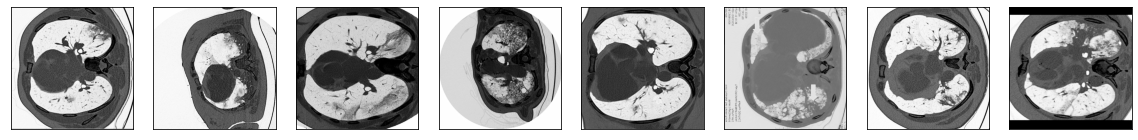

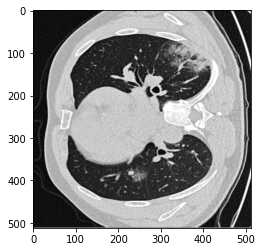

In [ ]:
visualize(test_images)

im = np.squeeze(test_images[0])
plt.imshow(im, cmap='gray')

In [ ]:
val_indexes, train_indexes = list(range(24)), list(range(24, 100))

train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg[train_indexes], masks_radiopedia))

training_images = train_images[:-200]
training_masks = train_masks[:-200]

del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class CovidDataset(torch.utils.data.Dataset):
    
    def __init__(self,
                image,
                mask,
                transform):
        self.image = image
        self.mask = mask
        self.transform = transform
        
    def __getitem__(self,i):
        
        image = self.image[i]
        mask = self.mask[i]
        mask = mask[:,:,0]
        
        image = self.transform(image)
        mask = self.transform(mask)
        
        return image, mask
        
    def __len__(self):
        return len(self.image)

In [ ]:
from sklearn.model_selection import train_test_split
import cv2
O_train, O_test, gt_train, gt_test = train_test_split(training_images, training_masks, test_size = 0.20, random_state = 42)

trans_training = transforms.Compose([transforms.ToTensor(), transforms.Resize((128,128), interpolation = cv2.INTER_NEAREST),transforms.RandomRotation(10)])
trans_valid = transforms.Compose([transforms.ToTensor(), transforms.Resize((128,128), interpolation = cv2.INTER_NEAREST)
                            ])

train_dataset = CovidDataset(
    O_train, 
    gt_train, 
    transform = trans_training
)

valid_dataset = CovidDataset(
    O_test,
    gt_test,
    transform = trans_valid
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=2)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


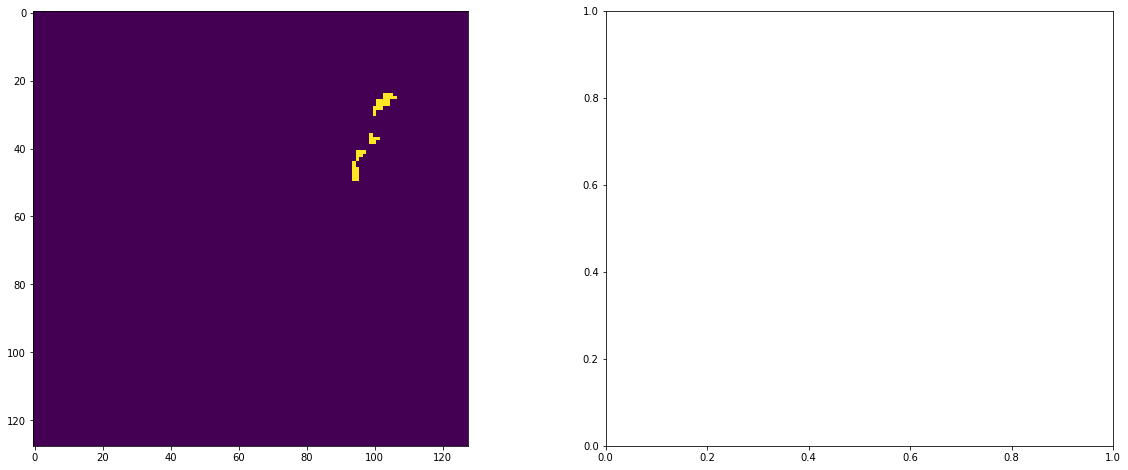

In [ ]:
for image, label in train_loader:
  break

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(label[0].data.cpu()))
plt.subplot(1, 2, 2)
#plt.imshow(np.squeeze(out2[0].data.cpu()))
plt.show()


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):

  def __init__(self, n_channels, n_classes, bilinear):
    super(UNet, self).__init__()
    self.inc = inconv(n_channels, 64)
    self.down1 = down(64, 128)
    self.down2 = down(128, 256)
    self.down3 = down(256, 512)
    self.down4 = down(512, 512)
    self.up1 = up(1024, 256, bilinear)
    self.up2 = up(512, 128, bilinear)
    self.up3 = up(256, 64, bilinear)
    self.up4 = up(128, 64, bilinear)
    self.outc = outconv(64, n_classes)
    self.act = nn.Sigmoid()
    
  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    x = self.outc(x)
    x = self.act(x)
    return x

  
class double_conv(nn.Module):
  def __init__(self, in_ch, out_ch):
      super(double_conv, self).__init__()
      self.conv = nn.Sequential(
          nn.Conv2d(in_ch, out_ch, 3, padding=1),
          nn.BatchNorm2d(out_ch),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_ch, out_ch, 3, padding=1),
          nn.BatchNorm2d(out_ch),
          nn.ReLU(inplace=True)
      )

  def forward(self, x):
    x = self.conv(x)
    return x

class inconv(nn.Module):
  def __init__(self,in_ch,out_ch):
    super(inconv, self).__init__()
    self.conv = double_conv(in_ch, out_ch)
  
  def forward(self,x):
      x = self.conv(x)
      return x

class down(nn.Module):
  def __init__(self,in_ch,out_ch):
    super(down, self).__init__()
    self.mpconv= nn.Sequential(
        nn.MaxPool2d(2),
        double_conv(in_ch, out_ch)
    )

  def forward(self,x):
    x=self.mpconv(x)
    return x

class up(nn.Module):
    ''' upsample -> conv '''
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)
    
    def forward(self, x1, x2):
        x1 = self.up(x1) # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2, diffY // 2, diffY - diffY//2))
        
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x
    
    
class outconv(nn.Module):
    ''' conv '''
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)
    
    def forward(self, x):
        x = self.conv(x)
        return x




In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
from tqdm import tqdm

device="cuda:0"
model=UNet(1,1,bilinear=True) 

model = model.to(device)

epochs = 30
criterion = nn.BCELoss() 

optimizer = torch.optim.Adam(model.parameters()) 
print(model.parameters())

training_size = len(train_loader.dataset)
valid_size = len(valid_loader.dataset)

for epoch in range(epochs):

  running_loss = 0.0
  accuracy = 0
  model.train()
 
  for image, label in tqdm(train_loader):

    optimizer.zero_grad()

    image = image.to(device)
    label = label.to(device)

    pred = model(image)

    loss = criterion(pred, label)
    
    running_loss += loss.item()

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


  print('Loss/train', running_loss / training_size)

  running_loss_val = 0.0
  
  running_dice = 0.0
  
  for image, label in tqdm(valid_loader):
    model.eval()
    

    
    optimizer.zero_grad()

    image = image.to(device)
    label = label.to(device)

    pred = model(image)

    loss = criterion(pred, label)

    running_loss_val += loss

  print('Val_Loss/val', running_loss_val / valid_size )



  0%|          | 0/564 [00:00<?, ?it/s]

<generator object Module.parameters at 0x7f317379e2d0>


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.09192778210730311


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.045098015094829844


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0280, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.04173579082183593


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0260, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.03707212336354803


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0426, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.03662802885201469


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0327, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.036165539426885954


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0400, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.0343063919986012


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0435, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.034698565647828375


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0248, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.030140764416952563


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0235, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.030434407915710306


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0254, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.030111262020374258


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0451, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.030839527957502617


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0311, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.029382057073802675


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0324, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.029524393425666123


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0604, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.028581893964875357


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0417, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.02816698121668396


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0251, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.025670185650351864


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0374, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.028354177610973037


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0324, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.028686804719132427


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0358, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.026212198565525608


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0346, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.0275858722026303


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0320, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.02676005885734141


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0386, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.025655698368951457


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0392, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.027264003656842336


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0310, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.025352575316714435


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0360, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.02448030835383321


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0311, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.024821642217088446


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0304, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.02486165714425308


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0280, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.023844519413866325


  0%|          | 0/564 [00:00<?, ?it/s]

Val_Loss/val tensor(0.0442, device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Loss/train 0.024250747715002765


100%|██████████| 141/141 [00:02<00:00, 49.02it/s]

Val_Loss/val tensor(0.0452, device='cuda:0', grad_fn=<DivBackward0>)


ValueError: ignored

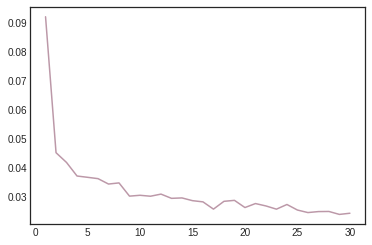

In [ ]:
epoch = np.arange(1,31,1).tolist()
trening = [0.09192778210730311,0.045098015094829844, 0.04173579082183593, 0.03707212336354803, 0.03662802885201469, 0.036165539426885954, 0.0343063919986012,0.034698565647828375,0.030140764416952563, 0.030434407915710306, 0.030111262020374258,  0.030839527957502617, 0.029382057073802675, 0.029524393425666123, 0.028581893964875357, 0.02816698121668396,0.025670185650351864,0.028354177610973037,0.028686804719132427,0.026212198565525608,0.0275858722026303,0.02676005885734141,0.025655698368951457,0.027264003656842336,0.025352575316714435,0.02448030835383321,0.024821642217088446,0.02486165714425308,0.023844519413866325,0.024250747715002765 ]
valid = [0.0336, 0.0280,0.0260,0.0426,0.0327,0.0400,0.0435,0.0235,0.0254,0.0451,0.0311,0.0324,0.0604,0.0417, 0.0251,0.0374,0.0324,0.0358,0.0346,0.0320, 0.0386, 0.0392,0.0310,0.0360,0.0311,0.0304,0.0280,0.0442,0.0452 ]

plt.figure()

plt.style.use("seaborn-white")
plt.plot(epoch,trening, color = "#bc98a8")
plt.plot(epoch, valid, color = "#e8c6ba")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")

cr = ["Training","Validation"]
plt.legend(cr)

plt.show()

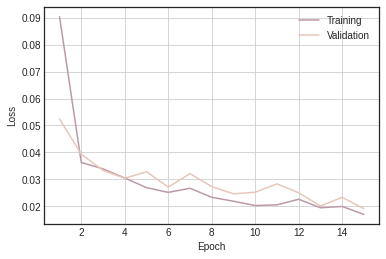

In [ ]:
epoch = np.arange(1,16,1).tolist()
trening = [0.09035821402435527, 0.03625120056201935, 0.033876134059969865, 0.030483616709709994, 0.026904978378632944,  0.025141415224618654, 0.026674202713720726, 0.023321968213083712, 0.021857264604993702, 0.020258652881716282,  0.020505525362066897, 0.022590541321468864, 0.019437780848620474,  0.019915770031020526, 0.01696216434142606]
valid = [0.0524,0.0393,0.0333,0.0304,0.0328,0.0271,0.0321,0.0273,0.0246,0.0252,0.0283,0.0250,0.0201,0.0233,0.0191]

plt.figure()

plt.style.use("seaborn-white")
plt.plot(epoch,trening, color = "#bc98a8")
plt.plot(epoch, valid, color = "#e8c6ba")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")

cr = ["Training","Validation"]
plt.legend(cr)

plt.show()


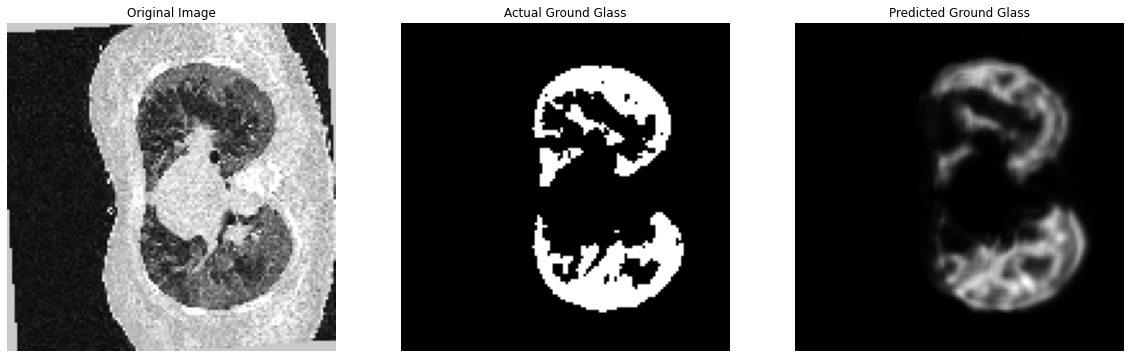

In [ ]:
from sklearn.metrics import jaccard_score



for images, labels in train_loader:
  images = images.to(device)
  labels = labels.to(device)
  

  break

out = model(images)



#predicted = np.squeeze(out[0].data.cpu())
#actual = np.squeeze(labels[0].data.cpu())

#predicted = np.ravel(predicted)
#actual = np.ravel(actual)


#def dice(pred, true,k=1):
#    intersection = np.sum(pred[true==k]) * 2.0
#    dice = intersection / (np.sum(pred) + np.sum(true))
#    return dice

#d = dice(pr,actual) 
#print(d)   

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("Original Image")
plt.imshow(np.squeeze(images[0].data.cpu()), cmap="gray")
plt.subplot(1, 3, 2)
plt.axis('off')
plt.title("Actual Ground Glass")
plt.imshow(np.squeeze(labels[0].data.cpu()), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(out[0].data.cpu()), cmap='gray')
plt.title("Predicted Ground Glass")
plt.axis('off')
plt.show()

torch.Size([1, 1, 128, 128])


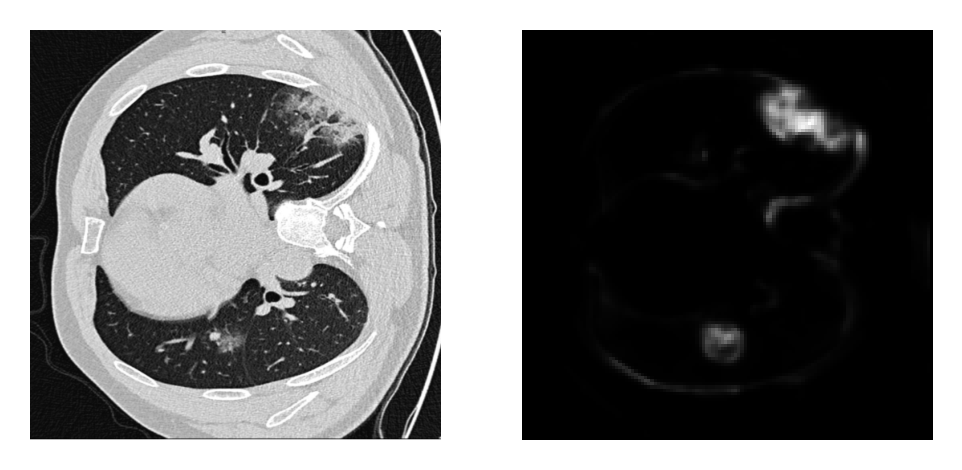

In [ ]:
import scipy

out1 = (np.squeeze(test_images[0]))
out1 = trans_valid(out1)
out1 = torch.unsqueeze(out1,1)
print(out1.shape)

out1 = out1.to(device)

result = model(out1)

wynik = np.squeeze(result[0].data.cpu())
#wynik = scipy.ndimage.zoom(wynik,(256,256))
plt.figure(dpi = 300)
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(np.squeeze(test_images[0]), cmap='gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(wynik,cmap='gray')
